In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
from jax import grad, value_and_grad
from plotting import plotx
from grid_utils import identity_mapping
import similarity
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, zoom
from plotting import show_warp_field
import numpy as np
import SimpleITK as sitk
import copy
import nibabel as nib

In [2]:


def get_warp_field(disp):
    nd, w, h = disp.shape
    id_map = identity_mapping((w, h))
    def_map = id_map + disp
    return def_map[::-1, :, :]

def compose_displacement_fields_sitk(d1, d2, spacing):
    """
    composition of the field phi with the new displacement field 
    """
    spacing = [spacing, spacing]
    ndim, w, h = d1.shape
    
    d1_sitk = _format_field_for_sitk_np(d1)
    d2_sitk = _format_field_for_sitk_np(d2)
    
    d1_sitk = sitk.GetImageFromArray(d1_sitk, isVector = True)
    d1_sitk.SetSpacing(spacing)
    
    d1_sitk.SetOrigin((0, 0))
    
    d2_sitk = sitk.GetImageFromArray(d2_sitk, isVector=True)
    d2_sitk.SetOrigin((0, 0))
    d2_sitk.SetSpacing(spacing)
    
    d1_sitk_tx = sitk.DisplacementFieldTransform(d1_sitk)
    d2_sitk_tx = sitk.DisplacementFieldTransform(d2_sitk)
    compose = sitk.CompositeTransform([d1_sitk_tx, d2_sitk_tx])
    composite_disp = sitk.TransformToDisplacementField(compose, size=(w, h), outputOrigin=(0, 0), outputSpacing= spacing)
    composed = sitk.GetArrayFromImage(composite_disp)
    composed = _format_field_for_jax(composed)
    
    return composed


def invert_displacement_field_sitk(disp_field, spacing):
    """
    inverts the displacement field using a fixed point iterative scheme
    right now boundary condition is not being enforced can be done by changing
    the filter being used for inversion 
    """
    ndim, w, h = disp_field.shape
    disp_f = np.zeros((w, h, ndim))
    spacing = (spacing, spacing)
    for i in range(ndim):
        disp_f[..., i] = disp_field[i, ...]
        
    disp_f = disp_f.astype(float)
    field = sitk.GetImageFromArray(disp_f, isVector=True)
    field.SetSpacing(spacing)
    field.SetOrigin((0, 0))
    
    inverse = sitk.InvertDisplacementField(field, maximumNumberOfIterations=1000,
    maxErrorToleranceThreshold=0.001,
    meanErrorToleranceThreshold=0.0001,
    enforceBoundaryCondition=True)
    
    field_inv =  _format_field_for_jax(sitk.GetArrayViewFromImage(inverse))
    return field_inv



def downsample_image(fix, shrink_factor, smoothing_sigma):
    zoom_factor = 1. / shrink_factor
    fix_smooth = gaussian_filter(fix, smoothing_sigma)
    im_res = zoom(fix_smooth, zoom_factor, order = 3, mode = "reflect")
    return im_res

def expand_displacement_field(phi, zoom_factor, order = 3, mode = "nearest"):
    
    ndim, _,_ = phi.shape
    return jnp.asarray([zoom(phi[i, ...], zoom_factor, order=order, mode=mode)
                    for i in range(ndim)])


def _format_field_for_sitk_np(field):
    ndim, w, h = field.shape
    sitk_field  = np.zeros((w, h, ndim))
    for i in range(ndim):
        sitk_field[..., i] = field[i, ...]
    sitk_field = sitk_field.astype(float)
    return sitk_field

def _format_field_for_jax(sitk_field):
    w, h, ndim = sitk_field.shape
    jax_field = np.zeros((ndim, w, h))
    for i in range(ndim):
        jax_field[i, ...] = sitk_field[..., i]
    return jax_field

def smooth(field, sigma = 2.):
    ndim, w, h = field.shape
    field_smoothed = np.zeros((ndim, w, h))
    for i in range(ndim):
        field_smoothed[i, ...] = gaussian_filter(field[i, ...], sigma)
    return field_smoothed 

def warp_image_with_displacement_field_sitk(im, disp_field):
    
    disp_field = _format_field_for_sitk_np(disp_field)
    disp_field = sitk.GetImageFromArray(disp_field, isVector=True)
    im = sitk.GetImageFromArray(im)
    
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(im)
    disp_tx = sitk.DisplacementFieldTransform(sitk.Cast(disp_field,sitk.sitkVectorFloat64))
    resampler.SetTransform(disp_tx)
    out = sitk.GetArrayFromImage(resampler.Execute(im))
    return out

def normalize_steps(gradient, step_size, spacing):
    
    gradient = gradient/spacing
    scale = step_size / jnp.linalg.norm(gradient, axis=-1).max()
    return scale

def set_bc(gradient):
    gradient = gradient.at[:, :, :1].set(0.)
    gradient = gradient.at[:, :, -2:].set(0.)
    gradient = gradient.at[:, :1, :].set(0.)
    gradient = gradient.at[:, -2:, :].set(0.)
    return gradient

def warp_image_with_displacement_field_jax(im, disp_field, spacing):
    
    """
    here can do one better instead of reassignment do a thing with jax.roll or swapaxes or somehting 
    so im doing somehting like function in and function out 
    
    """
    
    ix, iy = identity_mapping(im.shape)
    dx, dy = disp_field
    dix, diy = ix + dx , iy + dy
    
    return jax.scipy.ndimage.map_coordinates(im, jnp.asarray([diy, dix]), order = 1)

def warp_image_with_displacement_field_jax_pure(im, disp_field, spacing):
    
    """
    here im switching the channel ordering in a pure way just have to make sure that 
    it is differentiable 
    """
    
    id_map = identity_mapping(im.shape)
    def_map = id_map + disp_field #/ spacing
    
    
    return jax.scipy.ndimage.map_coordinates(im, def_map[::-1, :, :], order = 1)
    
def get_loss_fn(fix_level, mov_level, disp_fix_to_middle, disp_mov_to_middle, spacing):
    
    sh = fix_level.shape
    id_map = identity_mapping(sh)
    
    def_map_fix_to_middle = id_map + disp_fix_to_middle #/ spacing
    def_map_mov_to_middle = id_map + disp_mov_to_middle #/ spacing
    
    fix_to_middle = jax.scipy.ndimage.map_coordinates(fix_level, def_map_fix_to_middle[::-1, :, :], order = 1)
    mov_to_middle = jax.scipy.ndimage.map_coordinates(mov_level, def_map_mov_to_middle[::-1, :, :], order = 1)
    
    loss = (1/.5)**2*similarity.ssd(fix_to_middle, mov_to_middle)
    return loss

def value_and_grad_fun(fix_level, mov_level, disp_fix_to_middle, disp_mov_to_middle, spacing):
    
    sh = fix_level.shape
    w, h = sh
    id_map = identity_mapping(sh)
    
    def_map_fix_to_middle = id_map + disp_fix_to_middle #/ spacing
    def_map_mov_to_middle = id_map + disp_mov_to_middle #/ spacing
    
    fix_to_middle = jax.scipy.ndimage.map_coordinates(fix_level, def_map_fix_to_middle[::-1, :, :], order = 1)
    mov_to_middle = jax.scipy.ndimage.map_coordinates(mov_level, def_map_mov_to_middle[::-1, :, :], order = 1)
    
    loss = (1/.05)**2*jnp.sum((fix_to_middle - mov_to_middle)**2)
    
    
    df2m_grad =  jnp.asarray(jnp.gradient(fix_to_middle, spacing))
    dm2m_grad =  jnp.asarray(jnp.gradient(mov_to_middle, spacing))
    
    
    grad_fix_to_middle = 2*(1/.05)**2 * (fix_to_middle - mov_to_middle) * df2m_grad[::-1, :,:]
    grad_mov_to_middle =  2*(1/.05)**2 * (-fix_to_middle + mov_to_middle) * dm2m_grad[::-1,:,:]
    return loss, grad_fix_to_middle, grad_mov_to_middle
    

#value_and_grad_fun = value_and_grad(get_loss_fn, argnums = (2, 3))

In [3]:
fix = jnp.asarray(nib.load("circle.nii").dataobj)
mov = jnp.asarray(nib.load("square.nii").dataobj)

In [4]:
step_size = .25
num_levels = 3
num_iterations = [ 200, 100, 100]
smoothing_sigmas = [ 0.6, 0.2, 0.]
shrink_factors = [ 4, 2, 1]
spacings = shrink_factors


In [5]:
## define the kernel for computing the lncc 
kernel_cc = similarity._get_lcc_loss_kernel(3)
lncc = partial(similarity._lcc_loss_2d_kernels, kernel = kernel_cc)

## SyN Algorithm

**For each level of the gaussian pyramid**

**1. If not initialized yet -**

       1. Initialize a displacement field fix_to_middle and mov_to_middle and expand to current shape
       If the displacement field has been initialized this step carries it forward to the next step
       
**2. Dowsample fix and moving images to the current resolution and smoothing of the gaussian pyramid**

**3. For each level run the opitmization iterations ---**

       1. warp the fix and moving to the middle using respective displacement transform
       2. compute the loss and gradient wrt to the displacement field (using autodiff) -- needs a fix for now i am doing an analytical gradient 
       3. set bc condition i.e. set displacement gradient at boundaries to be 0
       4. set the step_size of gradient descent update to be step_size = step_size / (grad / spacing).norm().max()
       5. update the displacement field as field = field - step_size * (smooth_gaussian_filter(grads)) for both fields
       6. monitor loss and convergence
       
**4. At the end of this level**

       1. Compute inverse of the displacement moving to middle, and fix to middle (use sitk.InvertDisplacementField)
       2. The full mapping is now given by moving to middle $\circ$ middle to fix and vice versa 
       
       

  0%|                                                                                                                              | 0/200 [00:00<?, ?it/s]

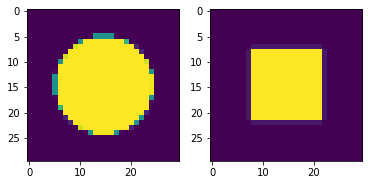

2250425000.0 18.081165 16.589956


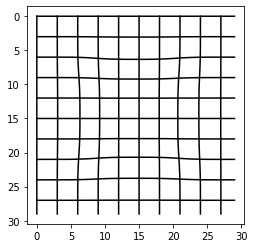

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 35.40it/s]


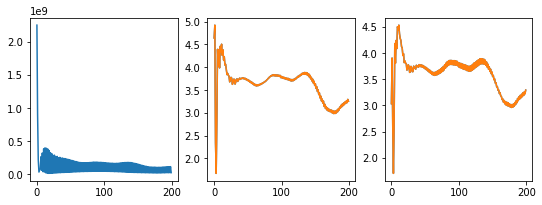

  0%|                                                                                                                              | 0/100 [00:00<?, ?it/s]

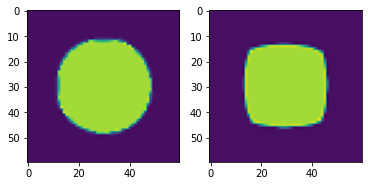

3398560800.0 9.693052 9.899793


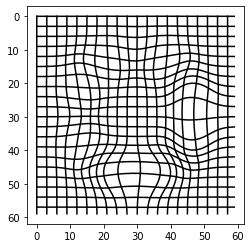

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.09it/s]


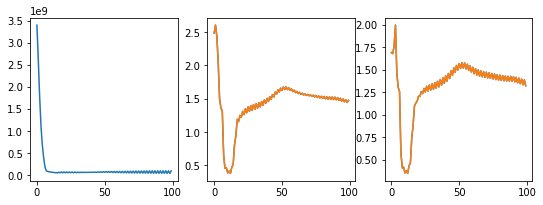

  0%|                                                                                                                              | 0/100 [00:00<?, ?it/s]

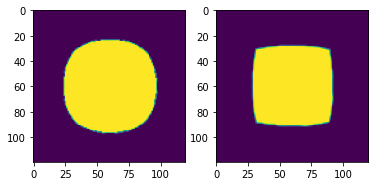

16662281000.0 5.702621 4.919218


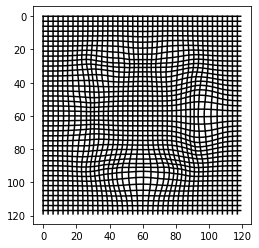

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.17it/s]


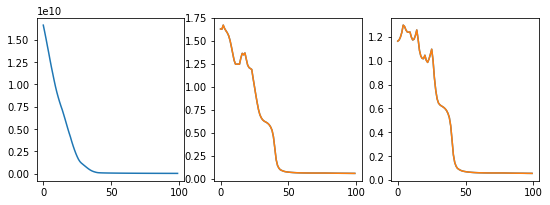

In [16]:

disp_fix_to_middle = None
disp_mov_to_middle = None
for level, iterations  in enumerate(num_iterations):
    
    spacing = shrink_factors[level]
    
    step_size = 1.5
    
    flow_sigma = 2.
    
    ## downsample images to current resolution and smoothing
    fix_level = downsample_image(fix, shrink_factors[level], smoothing_sigmas[level])
    mov_level = downsample_image(mov, shrink_factors[level], smoothing_sigmas[level])
    
    
    ## declare the displacement fields for SyN 
    if disp_fix_to_middle is None and disp_mov_to_middle is None:
        disp_fix_to_middle = jnp.zeros((2, *fix_level.shape))
        disp_mov_to_middle = jnp.zeros((2, *mov_level.shape))
    else:
        #zoom to current resolution warp the images and get going 
        zoom_factor_phi = fix_level.shape[-1]/disp_fix_to_middle.shape[-1]
        disp_fix_to_middle = expand_displacement_field(disp_fix_to_middle, zoom_factor_phi)
        disp_mov_to_middle = expand_displacement_field(disp_mov_to_middle, zoom_factor_phi)
        
    ## smoothers right now is a naive gaussian smoother maybe in future fix this 
    iteration = 0
    converged = False
    losses = []
    grads_1 = []
    grads_2 = []
    for i in tqdm(range(iterations)):
    #while(iteration < iterations and not converged):

        fix_to_middle = warp_image_with_displacement_field_jax_pure(fix_level, disp_fix_to_middle, spacing)
        mov_to_middle = warp_image_with_displacement_field_jax_pure(mov_level, disp_mov_to_middle, spacing)
        
        
        
        ## compute the losses and gradients of the displacement fields 
        loss, grad_fix_to_middle, grad_mov_to_middle = value_and_grad_fun(fix_level, mov_level, disp_fix_to_middle, disp_mov_to_middle, spacing)
        
        losses.append(loss)
        
        grad_fix_to_middle = set_bc(grad_fix_to_middle)
        grad_mov_to_middle = set_bc(grad_mov_to_middle)
        
        ## normalize the gradients by their norm
        scale_fix_to_middle = normalize_steps(grad_fix_to_middle, step_size, spacing)
        scale_mov_to_middle = normalize_steps(grad_mov_to_middle, step_size, spacing)

        #print (scale_fix_to_middle, scale_mov_to_middle)
        
        ## update the displacement fields 
        disp_fix_to_middle -= scale_fix_to_middle * smooth(grad_fix_to_middle, flow_sigma) 
        disp_mov_to_middle -= scale_mov_to_middle * smooth(grad_mov_to_middle, flow_sigma)
        
        grads_1.append(jnp.linalg.norm((scale_fix_to_middle * smooth(grad_fix_to_middle, flow_sigma)).reshape(2, -1), axis = -1))
        grads_2.append(jnp.linalg.norm((scale_mov_to_middle * smooth(grad_mov_to_middle, flow_sigma)).reshape(2, -1), axis = -1))
        
        if i %500 == 0:
            plotx(fix_to_middle, mov_to_middle)
            print (loss, scale_fix_to_middle*jnp.linalg.norm(grad_fix_to_middle), scale_fix_to_middle*jnp.linalg.norm(grad_mov_to_middle))

            show_warp_field(get_warp_field(disp_mov_to_middle), interval=3, shape = disp_mov_to_middle.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)
    
    f, a = plt.subplots(1, 3, figsize =(9, 3))
    a[0].plot(losses)
    a[1].plot(grads_1)
    a[2].plot(grads_2)
    plt.show()
    
    ## invert the displacement fields to go in the opposite direction 
    disp_middle_to_fix = invert_displacement_field_sitk(disp_fix_to_middle, spacing)
    disp_middle_to_mov = invert_displacement_field_sitk(disp_mov_to_middle, spacing)
    
    ## update the full displacement field by composing the two halves of the displacement fields 
    disp_fix_to_mov = compose_displacement_fields_sitk(disp_fix_to_middle, disp_middle_to_mov, spacing)
    disp_mov_to_fix = compose_displacement_fields_sitk(disp_mov_to_middle, disp_middle_to_fix, spacing)
    

In [17]:
### deformation map for the moving to mid

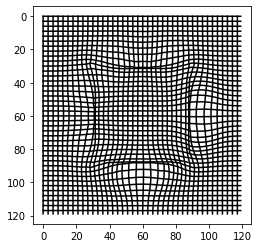

In [18]:
show_warp_field(get_warp_field(disp_mov_to_middle[:,:,:] ), interval=3, shape = disp_mov_to_middle.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)

In [19]:
## deformation map for middle to fix

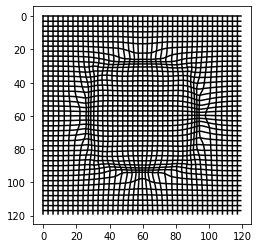

In [20]:
show_warp_field(get_warp_field(disp_middle_to_fix[:,:,:] ), interval=3, shape = disp_middle_to_fix.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)

In [21]:
## deformation map for mov to fix

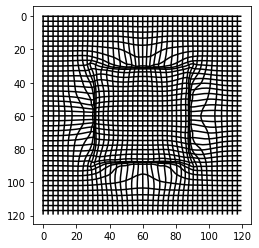

In [22]:
show_warp_field(get_warp_field(disp_mov_to_fix[:,:,:] ), interval=3, shape = disp_mov_to_fix.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)

### first warp the images by the two halves 

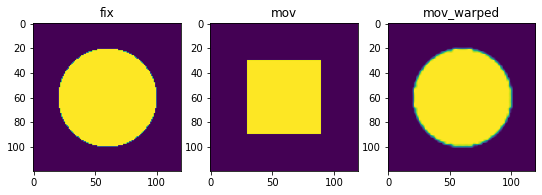

In [23]:
warps = [disp_mov_to_middle, disp_middle_to_fix]
mov_w  = copy.deepcopy(mov)
for w in warps:
    mov_w = warp_image_with_displacement_field_jax(mov_w, w, 1)

titles = [ "fix", "mov", "mov_warped"]
f, a = plt.subplots(1, 3, figsize =(9, 3))
a[2].imshow(mov_w)
a[0].imshow(fix)
a[1].imshow(mov)
for i in range(3):
    a[i].set_title(titles[i])

## now warp by the composite field i.e. disp_mov_to_middle composed with disp_middle_to_fix

In [24]:
mov_warped_by_composite = warp_image_with_displacement_field_jax(mov, disp_mov_to_fix, 1)

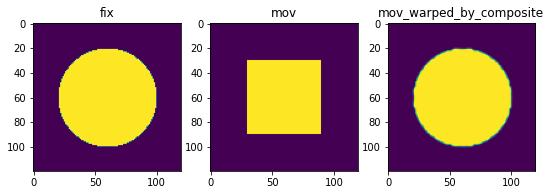

In [25]:
titles = [ "fix", "mov", "mov_warped_by_composite"]
f, a = plt.subplots(1, 3, figsize =(9, 3))
a[2].imshow(mov_warped_by_composite)
a[0].imshow(fix)
a[1].imshow(mov)
for i in range(3):
    a[i].set_title(titles[i])